In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("train.csv")

print("setup complete")

setup complete


In [2]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
categorical = [col for col in df.columns if(df[col].dtypes == "O")]
numerical = [col for col in df.columns if(df[col].dtypes != "O")]


print(df.shape)

(891, 12)


In [4]:
df[categorical].describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [5]:
df[numerical].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

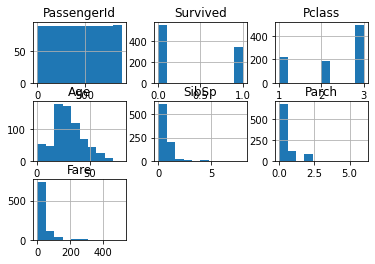

In [6]:
df[numerical].hist()

# Models

Here we will define all the modelling function to return the score for each dataset given. We will use this to pick the 
best preprocessing and modelling technqiue.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
print("lib loaded")

lib loaded


In [57]:



def utilCheckModel(processor, max_leaf_nodes, train_X, valid_X, train_y, valid_y):
    model = RandomForestClassifier(n_estimators = 400, max_leaf_nodes = max_leaf_nodes, random_state = 0, n_jobs = -1)
    my_pipeline = Pipeline(steps = [
        ('preprocessor', processor),
        ('model', model)
    ])
    try:
        my_pipeline.fit(train_X, train_y)
        pred_y = my_pipeline.predict(valid_X)
        return accuracy_score(valid_y, pred_y)
    except ValueError:
        print("Obtained ValueError")
        return 0

def checkModel(processor, train_X, valid_X, train_y, valid_y):
    bestNodeVal = 0
    bestNodeScore = 0
    input = [_ for _ in range(5, 50)]
    output = []
    for leaf in range(5, 50):
        scoreHere = utilCheckModel(processor, leaf, train_X, valid_X, train_y, valid_y)
        if(scoreHere > bestNodeScore):
            bestNodeScore = scoreHere
            bestNodeVal = leaf
        output.append(scoreHere)
    plt.figure(figsize = (16, 6))
    sns.lineplot(x = input, y = output)
    plt.show()
    return (bestNodeVal, bestNodeScore)


In [9]:
df.drop(["PassengerId", "Name", "Ticket"], axis = 1, inplace=True) # highly cardinal columns
X = df.drop("Survived", axis = 1)
y = df["Survived"]


In [10]:
categorical = [col for col in X.columns if(df[col].dtypes == "O")]
numerical = [col for col in X.columns if(df[col].dtypes != "O")]
X['Cabin'] = X['Cabin'].str[0]


In [11]:
print(categorical)
print(numerical)

['Sex', 'Cabin', 'Embarked']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [12]:

numerical_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
    ])
categorical_transformer1 = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = "most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown = "ignore")),
])

categorical_transformer2 = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = "most_frequent")),
    ('woe', ce.HelmertEncoder()),
])

preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer, numerical),
    ('cat1', categorical_transformer1, ['Sex', 'Embarked']),
    ('cat2', categorical_transformer2, ['Cabin'])
])

In [13]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.8, random_state=1)

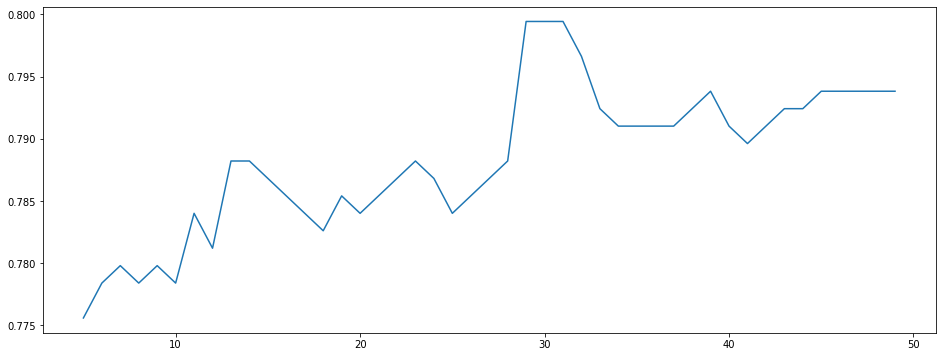

(29, 0.7994389901823282)


In [58]:
import warnings
warnings.filterwarnings('ignore')
print(checkModel(preprocessor, X_train, X_valid, y_train, y_valid))

# TEST RESULT GENERATION

In [15]:
test_df = pd.read_csv("test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [16]:
psgId = test_df["PassengerId"]
test_df.drop(["PassengerId", "Name", "Ticket"], axis = 1, inplace=True)
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,34.5,0,0,7.8292,NaN,Q
1,3,female,47.0,1,0,7.0000,NaN,S
2,2,male,62.0,0,0,9.6875,NaN,Q
3,3,male,27.0,0,0,8.6625,NaN,S
4,3,female,22.0,1,1,12.2875,NaN,S


In [59]:
final_model = RandomForestClassifier(n_estimators = 400,max_leaf_nodes = 29, random_state = 1, n_jobs = -1)
final_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', final_model)
])

final_pipeline.fit(X, y)
y_pred = final_pipeline.predict(test_df)

In [60]:
res = pd.DataFrame({
    'PassengerId' : psgId,
    'Survived' : y_pred
})

In [61]:
res.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [62]:
res.to_csv("submission3.0.csv", index=False)

In [63]:
check = pd.read_csv("submission3.0.csv")
check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
